In [1]:
import numpy as np
import matplotlib.pyplot as plt

from framework_pkg.framework import FrameWork

plt.rcParams['text.usetex']=True
plt.style.use('classic')

param = {'SinT12': 0.308, 'M12': 6.9e-5}

In [2]:
""" expected event rate per day per 32.5 kilo ton assuming no oscillation 
(The value should be matched with 294.7 per day per 32.5 kilo ton) """

frame_expected_event_rate  = FrameWork(threshold=3.5,
                                        efficiency_correction=False,
                                        resolution_correction=False,
                                        first_day='2008,9,15',
                                        last_day='2018,5,30'
                                    )

mc_expected_event = frame_expected_event_rate.unoscillated_expected_event_rate
msw_signal_fraction = frame_expected_event_rate.__getitem__(param, name="MSW") 
msw_expected_event = frame_expected_event_rate._pridection_function()

print(mc_expected_event)
print(msw_signal_fraction)
print(msw_expected_event)

[294.63483945]
[0.4624133]
[136.24306959]


In [3]:
""" predicted fraction of total signal in comparsion to expected unoscillation total signal """


frame_predicted_total_signal  = FrameWork(threshold=3.5,
                                        efficiency_correction=True,
                                        resolution_correction=False,
                                        first_day='2015,1,1',
                                        last_day='2016,1,1'
                                    )

predicted_total_signal = frame_predicted_total_signal.__getitem__(param, name="MSW") 

print(predicted_total_signal)

[0.43368273]


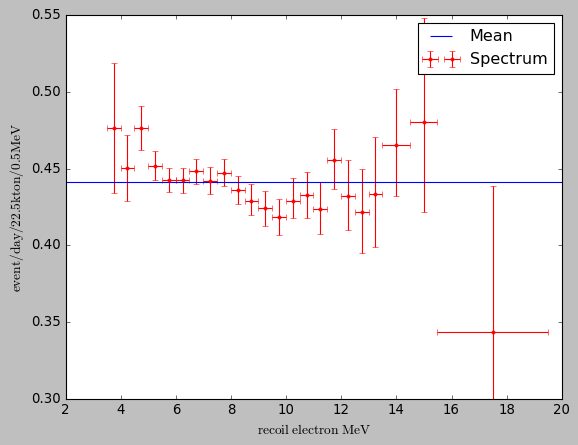

In [4]:
"""data illustration : B8 and hep
in comparsion with Fig 37 in paper Phys. Rev. D 109, 092001 (2024).
"""

frame_expected_spectrum  = FrameWork(threshold=3.5,
                                     efficiency_correction=False,
                                     resolution_correction=True,
                                     first_day='2015,1,1',
                                     last_day='2016,1,1')

spectrum_data = frame_expected_spectrum.spectrum_data
energy_obs    = frame_expected_spectrum.energy_obs

plt.ylim(0.3,0.55)
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')

plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), spectrum_data[:,2] / (spectrum_data[:,11] + spectrum_data[:,12]),
             yerr = np.array([spectrum_data[:,4], spectrum_data[:,3]]) / (spectrum_data[:,11] + spectrum_data[:,12]), 
             xerr = 0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='r.')

plt.hlines(xmin=2,xmax=20,y=0.441)

plt.legend(['Mean','Spectrum'])

<ErrorbarContainer object of 3 artists>

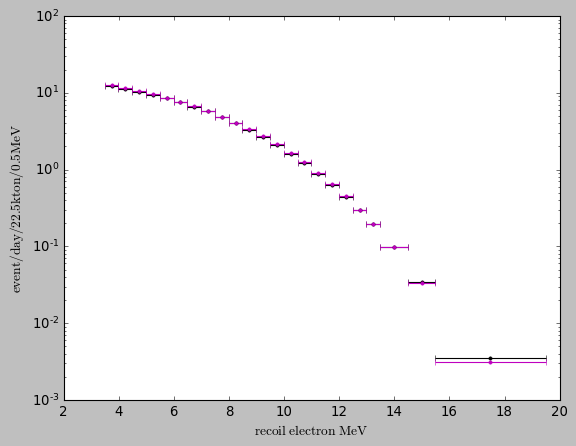

In [5]:
"""
Comparsion between our predection and the Fig36 in paper Phys. Rev. D 109, 092001 (2024).
expected B8 spectrum assuming no oscilation.
"""

b_un_per_day  = frame_expected_spectrum.unoscillated_expected_spectrum

plt.yscale('log')
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')
plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), (0.5 / (energy_obs[:,1] - energy_obs[:,0])) * spectrum_data[:,11] * 22.5 / 365.25,
             yerr=None, xerr = 0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='k.' )
plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), (0.5 / (energy_obs[:,1] - energy_obs[:,0])) * b_un_per_day ,
             yerr=None, xerr = 0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='m.')


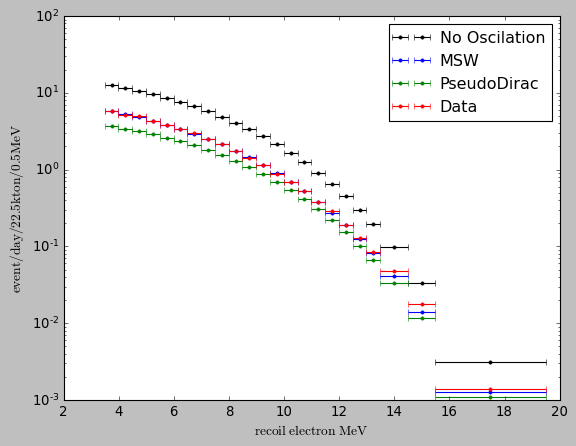

In [6]:

"""
B8 spectrum predection
"""
param = {'SinT12': 0.308, 'M12': 7.5e-5}

msw_fraction = frame_expected_spectrum.__getitem__(param, name="MSW") 
spectrum_event_per_day = frame_expected_spectrum._pridection_function()

PD_fraction = frame_expected_spectrum.__getitem__(param, name="PseudoDirac") 
spectrum_event_per_day2 = frame_expected_spectrum._pridection_function()


plt.yscale('log')
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')

plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * b_un_per_day,
             yerr=None,  xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='k.')
plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * spectrum_event_per_day,
             yerr=None, xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='b.')
plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * spectrum_event_per_day2,
             yerr=None, xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='g.')
plt.errorbar(0.5 * (energy_obs[:,1]+energy_obs[:,0]), (0.5/(energy_obs[:,1] - energy_obs[:,0])) * spectrum_data[:,2] * 22.5 / 365.25 ,
             yerr=None,  xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='r.')

plt.legend(['No Oscilation', 'MSW', 'PseudoDirac', 'Data'])

day
0.43431035208888763
night
0.45136589196236204
all
0.4430360899043997
MSW prediction
0.43368702922168756


<ErrorbarContainer object of 3 artists>

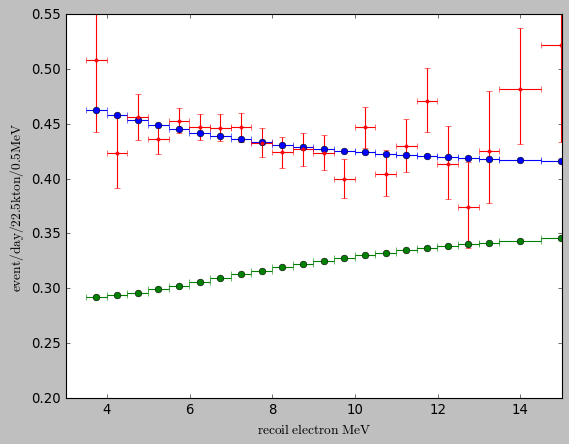

In [7]:
"""Observed only B8_per_day spectrum data and MSW prediction"""
bin_number = 20

print('day')
print(np.mean(spectrum_data[:bin_number,5]/(spectrum_data[:bin_number,11])))

print('night')
print(np.mean(spectrum_data[:bin_number,8]/(spectrum_data[:bin_number,11])))

print('all')
print(np.mean(spectrum_data[:bin_number,2]/(spectrum_data[:bin_number,11])))


print('MSW prediction')
print(np.mean((msw_fraction)[:bin_number]))

plt.xlim(3,15)
plt.ylim(0.2,0.55)
plt.ylabel(r'$\rm event/day/22.5kton/0.5MeV$')
plt.xlabel(r'$\rm recoil \ electron \ MeV$')

plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), PD_fraction,
             yerr=None, xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='go')


plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), msw_fraction,
             yerr=None, xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='bo')


plt.errorbar(0.5 * (energy_obs[:,1] + energy_obs[:,0]), spectrum_data[:,5] / (spectrum_data[:,11]),
             yerr= np.array([spectrum_data[:,7],spectrum_data[:,6]])/(spectrum_data[:,11]),
             xerr =0.5 * (energy_obs[:,1] - energy_obs[:,0]), fmt='r.')
